In [2]:
import numpy as np
import pandas as pd
import json
import sklearn as skl
from sklearn.model_selection import GroupShuffleSplit

In [3]:
movies = pd.read_csv("./ml-latest-small/movies.csv")
# movies['genres'].str.split('|')
# set(itertools.chain.from_iterable(movies.genres))
# np.unique([*itertools.chain.from_iterable(movies.genres)])
genre = {}
for l in movies['genres'].str.split('|'):
    for g in l:
        if g not in genre:
            genre[g] = 1
        else:
            genre[g] += 1
            
genre
# movies.head()


{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [4]:
genretoidx = {}
idxtogenre = []
for i, g in enumerate(genre):
    # print(g, i)
    genretoidx[g] = i
    idxtogenre.append(g)
    
# print(genretoidx, idxtogenre)

In [5]:
def toVec(genres):
    vec = [0] * 20
    # print(genres)
    for g in genres.split('|'):
        # print(g)
        vec[genretoidx[g]] += 1
    return vec
    
genredict = {m[0] : toVec(m[1]) for m in movies[['movieId','genres']].to_numpy()}
# print(genredict)
# json.dumps(genredict)
with open('data.json', 'w') as fp:
    json.dump(genredict, fp)

In [6]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
# ratings.groupby('userId').transform(lambda x: (x - x.mean()) / x.std())
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
def fx(rating, movieId):
    # print(genredict[movieId], rating)
    return (rating * np.array(genredict[movieId])).astype(object)
ratings['rating'] = ratings.groupby('userId')['rating'].transform(lambda x: (x - x.mean()) / x.std())
ratings['genrating'] = np.vectorize(fx)(ratings['rating'], ratings['movieId'])
ratings.head()

,userId,movieId,rating,timestamp,genrating
0,1,1,-0.457947,964982703,"[-0.45794663435835353, -0.45794663435835353, -..."
1,1,3,-0.457947,964981247,"[-0.0, -0.0, -0.0, -0.45794663435835353, -0.0,..."
2,1,6,-0.457947,964982224,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
3,1,47,0.791978,964983815,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,50,0.791978,964982931,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.791..."


In [8]:
scores = ratings.groupby('userId')['genrating'].sum()
# np.argsort(scores[1])
scores

userId
1      [2.3220588165700233, 11.71804623211082, 9.5145...
2      [0.8132579362354637, 0.0, 0.0, 0.4494320173932...
3      [1.5330834557146171, -3.7039296290065127, -4.6...
4      [2.1982045396984713, 2.0291118827985866, 1.860...
5      [-3.1207416126885827, 4.222179828931615, 4.313...
                             ...                        
606    [-31.262294220035166, 3.299502864473409, -14.1...
607    [-14.885542842999017, -2.813190388483445, -7.1...
608    [14.560134050947918, -0.8150597688281738, -54....
609    [-1.5607805854879246, -0.600300225187664, -1.2...
610    [5.429683116080637, 16.392510273740378, -2.401...
Name: genrating, Length: 610, dtype: object

In [14]:
users = (ratings.groupby(['userId']).size()).to_frame(name="rated")
users["scores"] = scores
users

,rated,scores
userId,,
1,232,"[2.3220588165700233, 11.71804623211082, 9.5145..."
2,29,"[0.8132579362354637, 0.0, 0.0, 0.4494320173932..."
3,39,"[1.5330834557146171, -3.7039296290065127, -4.6..."
4,216,"[2.1982045396984713, 2.0291118827985866, 1.860..."
5,44,"[-3.1207416126885827, 4.222179828931615, 4.313..."
...,...,...
606,1115,"[-31.262294220035166, 3.299502864473409, -14.1..."
607,187,"[-14.885542842999017, -2.813190388483445, -7.1..."
608,831,"[14.560134050947918, -0.8150597688281738, -54...."


In [45]:
exploded = scores.apply(pd.Series).stack().reset_index(drop=True)
# exploded[1]
# print(type(exploded[1]))
exploded.max()
# exploded.round().clip(-10,10).hist()

237.78693982757756

In [46]:
train, test = skl.model_selection.train_test_split(ratings, test_size=0.2)
train.head()
train['rating'] = train.groupby('userId')['rating'].transform(lambda x: (x - x.mean()) / x.std())
train['genrating'] = np.vectorize(fx)(train['rating'], train['movieId'])
train.head()

,userId,movieId,rating,timestamp,genrating
59043,385,539,-0.415540,842892309,"[-0.0, -0.0, -0.0, -0.4155395955918794, -0.0, ..."
91591,594,1707,0.017434,1138587710,"[0.0, 0.0, 0.01743417939969271, 0.017434179399..."
29282,201,293,-1.188893,940350410,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.188892..."
15867,103,70728,0.161191,1431956125,"[0.0, 0.0, 0.0, 0.16119104369577572, 0.0, 0.0,..."
14675,91,7650,0.094209,1112712463,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [47]:
temp= train['genrating'][16366].astype(float)
print(temp)
np.rint((10 / (1 + np.exp(-temp*0.2))))

[-0.         -0.         -0.         -0.         -0.         -0.17257399
 -0.17257399 -0.17257399 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.        ]


array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5.])

<AxesSubplot:>

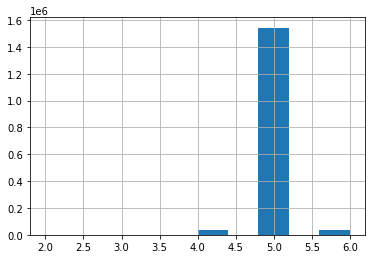

In [48]:
def gx(genrating):
    return np.rint((10 / (1 + np.exp(-genrating.astype(float)*0.2)))).astype(object)
train["sigmoid"] = np.vectorize(gx)(train['genrating'])
train.head()
train['sigmoid'].apply(pd.Series).stack().reset_index(drop=True).hist()


,genrating,scores
userId,,
1,"[1.857934997800074, 9.11427553116611, 7.672102...","[6.0, 9.0, 8.0, 2.0, 3.0, 5.0, 9.0, 5.0, 4.0, ..."
2,"[1.1462746905674253, 0.0, 0.0, -0.299028180148...","[6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
3,"[1.9145135145758285, -3.6712768519206906, -3.6...","[6.0, 3.0, 3.0, 3.0, 6.0, 3.0, 1.0, 9.0, 4.0, ..."
4,"[2.205499368791614, 1.7713459497381465, 1.1287...","[6.0, 6.0, 6.0, 6.0, 6.0, 3.0, 2.0, 3.0, 7.0, ..."
5,"[-4.98532631127075, 2.0829103081336697, 2.4243...","[3.0, 6.0, 6.0, 4.0, 6.0, 3.0, 7.0, 3.0, 6.0, ..."


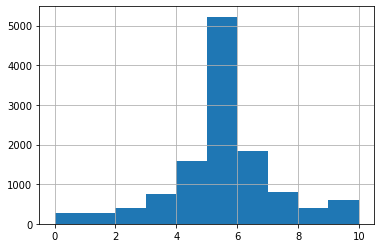

In [49]:
train_scores = train.groupby('userId')['genrating'].sum().to_frame()
# train_scores.type()
def gx(genrating):
    return np.rint((10 / (1 + np.exp(-genrating.astype(float)*0.2)))).astype(object)
train_scores["scores"] = np.vectorize(gx)(train_scores['genrating'])
train_scores['scores'].apply(pd.Series).stack().reset_index(drop=True).hist()
train_scores.head()

In [50]:
train.merge(train_scores, on='userId')
train.head()

,userId,movieId,rating,timestamp,genrating,sigmoid
59043,385,539,-0.415540,842892309,"[-0.0, -0.0, -0.0, -0.4155395955918794, -0.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
91591,594,1707,0.017434,1138587710,"[0.0, 0.0, 0.01743417939969271, 0.017434179399...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
29282,201,293,-1.188893,940350410,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.188892...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, ..."
15867,103,70728,0.161191,1431956125,"[0.0, 0.0, 0.0, 0.16119104369577572, 0.0, 0.0,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
14675,91,7650,0.094209,1112712463,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."


In [51]:
train.head()

,userId,movieId,rating,timestamp,genrating,sigmoid
59043,385,539,-0.415540,842892309,"[-0.0, -0.0, -0.0, -0.4155395955918794, -0.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
91591,594,1707,0.017434,1138587710,"[0.0, 0.0, 0.01743417939969271, 0.017434179399...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
29282,201,293,-1.188893,940350410,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.188892...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, ..."
15867,103,70728,0.161191,1431956125,"[0.0, 0.0, 0.0, 0.16119104369577572, 0.0, 0.0,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
14675,91,7650,0.094209,1112712463,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
